# 1: Real-time analysis of Wikipedia updates
# WikiRecentPhase1


## Continuous processing with Streams

[WikiRecentPhase0](https://github.com/IBMStreams/sample.wikirecent/raw/master/jupyter/imgAna_0.jupyter-py36.ipynb) illustrates accessing a continuous stream of events from a notebook in Python, as a way to explore the nature of the data and to understand how to develop it into useful insights. In that exploration data is collected and averages are calculated only as long as the notebook is open and specific cells are running. That model makes it challenging to make business use of insights derived from the stream.

In this notebook we transition the work we did with the data in step 0 to a continuously running Streams job, develop the insights further and show how the notebook can be used to access the outputs of the job for user visualization and action.

## Overview 
**About the sample** 

The application receives Wikipedia updates as events via SSE. An event
has a `bot` field indicating that it was generated by a bot. Many bots exist in Wikipedia to perform
mundane tasks: checking for copyright infringment, inappropriate content, and so on.
This application will focus on messages generated by humans, filtering out those from bots. 
The event has a number of superflous fields that are removed before it is presented in a "view". 

A _view_ enables a developer to observe data that is flowing through the live stream; data presented to the 
view is available for display over the web. Due to the real-time nature of Streams and the 
limitations of web communications, a view will drop observations as limits on resources (CPU, memory, bandwidth) start to bite. 
This has not been an issue so far with this suite of notebooks.

The application is composed in and submitted from the notebook; it runs on a service continuously until it is stopped. 
This notebook accesses and renders view data in order to see how the Streams application is processing the events 
received from Wikipedia. 

### Documentation

- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)
- [Topology](https://streamsxtopology.readthedocs.io/en/latest/index.html) Streams Topology documentation
- [Widgets](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) Notebook Widgets documentation.


## Submit an appplication with a filter

- Rough-cut look at the data
- Plot the event `type` data
- Look at the filtered data

##  Collect in a window (buffer) and aggregate
- Last 1000 events in a local buffer & aggregate
- Render
- Push code to server

# Streams Service Setup<a name="setup"></a>

It only matters where the Streams service runs, not whether this notebook is run in IBM (Public) Cloud or IBM Cloud Pak for Data.
Of course, it is unlikely that you would submit a job to CP4D from the public cloud—CP4D is likely behind a firewall—but it is
entirely possible to submit a job from CP4D to a Streaming Analytics service in the public cloud.

In [ ]:
global cfg
cfg = None

## For a Streaming Analytics service on IBM Cloud
### Get service credentials for the Streaming Analytics service:
In IBM Cloud,
- ≡ Menu > Resource List > expand Services;
- (your Streaming Analytics service) > Service credentials > (if necessary: New credential⊕ >) View credentials > Copy to clipboard
- Paste into the next cell as the right side of the `streaming_analytics` assignment. 

In [ ]:
# @hidden_cell
streaming_analytics = {
  "apikey": "h-wgLCRCjWUz59jx-wDol5J0N0AU9riMm85tUJcXsymg",
  "iam_apikey_description": "Auto-generated for key 5b6d9c74-7a4f-4516-84cc-26ff470e1fc9",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/299d796d09082a3cea3f576950b57ab4::serviceid:ServiceId-278a997f-2e65-477e-9840-d4cc1c1845bf",
  "v2_rest_url": "https://svc-cf.us-south.streaming-analytics.cloud.ibm.com/v2/streaming_analytics/f25967ef-71f9-4dfb-a72f-64585b69c3e6"
}

In [15]:
vcap_conf = {'streaming-analytics': [{
                'name': 'Streaming Analytics Lite',
                'credentials': streaming_analytics}]
            }

## For an IBM Streams Add-on installed in Cloud Pak for Data

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

[See an example](https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif)

## Imports 

In [3]:
# Install components
!pip install --user SSEClient===0.0.22 --upgrade
!pip install --user --upgrade streamsx

  Created wheel for SSEClient: filename=sseclient-0.0.22-cp36-none-any.whl size=5224 sha256=c46722f0fbc97f3b363cab638eae2f804072d8570b5da66f54151cb935a71e37
  Stored in directory: /home/wsuser/.cache/pip/wheels/fc/b8/5c/c7e0a8161e61dc1ab00c0b5a1a34a3887eb47170ae1a46f7b1
Successfully built SSEClient
Requirement already up-to-date: streamsx in /home/wsuser/.local/lib/python3.6/site-packages (1.13.15)


Initial imports are in support of accessing Streams with Wikipedia data, 
subsequent are in support of rendering the results as they flow back from 
Streams. 

In [4]:
## Operational 
from streamsx.topology.topology import *
import streamsx.rest as rest
import streamsx.topology.context

from sseclient import SSEClient as EventSource

import urllib3

## Renderng
import pandas as pd
from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import json

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
%matplotlib inline

from streamsx.topology import context

print("streamsx package version: " + streamsx.topology.context.__version__)

streamsx package version: 1.13.15


## Helper functions used in interfacing  to Streams  
Make interacting with the Streams data friendlier.

In [5]:
def catchInterrupt(func):
    """Decorator: Catch keyboard interrupt to avoid losing the display.
       TODO * <view>.stop_data_fetch()  # stop
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt):
            pass

    return catch_interrupt

def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() with a button to stop updating. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period)
    
    # The button only works once. A stopped view update cannot be restarted.
    # To get updates, a new view (or the same view again) must be selected.
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display a view when selected from list. Use radio buttons.
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))
    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    
    # Create the event handler
    def on_change(b):
        """Process radio button events."""
        if (b['name'] == 'label'):     # The 'label' traitlet is what changes when the user clicks a button
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """Find a job by name running in the Streams instance."""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None
    
def get_view(instance, job_name=None, view_name="view"):
    """Get a view by name from a running Streams job."""
    job = find_job(instance, job_name)
    return job.get_views(view_name)
    

def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Job {} is not running.".format(job_name))
    else:
        views = job.get_views()
        view_events(views)
        
def list_jobs(_instance=None, cancel=False):
    """
    Interactively select jobs to cancel.
    
    Prompt with SelectMultiple widget; if there are no jobs running, present a blank list.
    """
    active_jobs = {"{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    # Present running jobs in a multiple-selection widget
    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    
    # Cancel the selected jobs in response to a button toggle
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    
    # Event handler: cancel job(s) and disable the widgets
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job: {} {}", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])
 

## Connect to the server :  ICP4D or Cloud instance -


In [20]:
def get_instance():
    """
    Setup to access your Streams instance.

    NOTE: The notebook should work within both Cloud and ICP4D. 
          Refer to the 'Setup' cells above.   
            
    Returns:
        instance : Access to Streams instance, used for submitting jobs and rendering views.
    """
    
    if cfg is not None:       # Streams service in ICP4D: allow unverified connections
        import urllib3
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    else:                     # Streaming Analytics in IBM Cloud
        print("Outside ICP4D")
        sc = rest.StreamingAnalyticsConnection(service_name=vcap_conf['streaming-analytics'][0]['name'], 
                                               vcap_services=vcap_conf)
        instance = sc.get_instances()[0]
    
    return instance,cfg

instance,cfg = get_instance()

Outside ICP4D


### List jobs to cancel
This notebook will submit a job named 'WikiPhase1'. If it's running you'll want to cancel it before submitting a new one. 

If the job list is empty, there's nothing to cancel, so just move on.

In [21]:
list_jobs(instance, cancel=True)

# Composing the Streams application
- Get data from Wikipedia usng SSE
- Filter data, separate the humans from the bots
- Set up views : allEvents, allHumans, paredHumans, paredAll

## Receive message updates from Wikipedia
As updates are made to Wikipidia pages the changes are sent over an SSE feed. The `get_events()` function receives the events and acts as a [source](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Topology.source) that pushes them onto the Streams streams.

This is functionally the same code as the _imgAna0_ notebook.

In [22]:
def get_events():
    """Fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)

## Filter messages
The [filter operator](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.filter) is used to allow through only messages not generated by bots.

## View into the live stream
The [view](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.view) enables access to the live stream at runtime. We spread them liberaly throughout the application to observe how the processing is proceeding.

## Compose, build and submit the Streams application.¶

The following Code cell composes the Streams application depicted here:

![graph of application](https://github.com/IBMStreams/sample.wikirecent/raw/master/jupyter/images/stillPhase1.jpg)

From a single event source (wikiEvents)' we are creating a topology that delivers two streams of derived information.
To make each step in this process accessible to examination we are declaring a view at each stage to look at the raw data and also to attach graphical visualizations. 

A Steams flow is composed by linking operator outputs to inputs.

Two streams are generated and three views are exposed.

1) All source events are exposed for viewing by the 'allEvents' view.

2) All the source events are sent to 'paredAll', where they are pared down to 6 fields and exposed for viewing. 
- The Wikipedia events are output from the _source_ method named 'wikiEvents' on the stream 'wiki_events'.
- The input to the _map_ method named 'paredAll' is 'wiki_events', where fields ('timestamp', 'type', 'wiki', 'bot', 'user', 'title') are extracted and output to stream 'pared_all'. 
- The input to the _view_ method named 'paredAll' is 'pared_all', where the tuples are exposed for viewing. 

3) All the source events on stream 'wiki_events' are sent to 'humanFilter', which only passes on tuples with a 'bot' field value of False; these tuples are then are pared down to 5 fields and exposed for viewing.
- The Wikipedia events are output from the _source_ method named 'wikiEvents' on the stream 'wiki_events'.
- The _filter_ method named 'humanFilter' outputs on the stream 'all_human' only tuples in which the 'bot' field value is False.
- The _map_ method named 'paredHuman' takes 'all_human' as input, extracts the fields ('timestamp', 'type', 'wiki', 'user', 'title') sends output to the stream 'pared_human'. 
- The input to the _view_ method named 'paredHuman' is 'pared_human', where the tuples are exposed for viewing. 

In [23]:
def WikiPhase1(jobName=None):
    """ Compose topology """
    
    # Any pip-installable package can be added to the Topology application bundle.
    topo = Topology(name=jobName)
    topo.add_pip_package('SSEClient===0.0.22')

    ## Receive wiki data 
    wiki_events = topo.source(get_events, name="wikiEvents")
    wiki_events.view(buffer_time=1.0, sample_size=1, name="allEvents", description="All wiki events")
    
    ## Extract only selected fields ("pare") 
    pared_all = wiki_events.map(lambda x : {'timestamp':x['timestamp'],
                                            'type':x['type'],
                                            'wiki':x['wiki'],
                                            'bot':x['bot'],
                                            'user':x['user'],
                                            'title':x['title']},
                                name="paredAll")
    pared_all.view(buffer_time=1.0, sample_size=200, name="paredAll", description="All events pared")
    
    ## Filter out bots 
    all_human = wiki_events.filter(lambda x: x['bot'] is False, name='humanFilter')

    ## Extract only selected fields ("pare")
    pared_human = all_human.map(lambda x : {'timestamp':x['timestamp'],
                                            'type':x['type'],
                                            'wiki':x['wiki'],
                                            'user':x['user'],
                                            'title':x['title']},
                                name="paredHuman")
    pared_human.view(buffer_time=1.0, sample_size=200, name="paredHuman", description="Human events pared")
    
    return ({"topo":topo})

## Submit topology : build/submit (ICP4D or Cloud)

In [24]:
resp = WikiPhase1(jobName="WikiPhase1")

if cfg is not None:     # Streams service in CP4D
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    submission_result = context.submit("DISTRIBUTED", resp['topo'], config=cfg)
else:                   # Streaming Analytics in IBM Cloud
    cloud = {
        context.ConfigParams.VCAP_SERVICES: vcap_conf,
        context.ConfigParams.SERVICE_NAME: vcap_conf['streaming-analytics'][0]['name'],
        context.ContextTypes.STREAMING_ANALYTICS_SERVICE: "STREAMING_ANALYTIC",
        context.ConfigParams.FORCE_REMOTE_BUILD: True,
    }
    submission_result = context.submit("STREAMING_ANALYTICS_SERVICE", resp['topo'], config=cloud)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: {}   Name: {}".format(submission_result['id'], submission_result['name']))

IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

JobId: 0   Name: WikiStreams::WikiPhase1_0


<a id='viewingData'></a>
## Viewing data 

The running application has a number of views to see what data is moving through. The following 
cell will fetch a view's queue and display its data when selected. 

|View name | Description |
|---------|-------------|
|allEvents  | all fields of all events  |
|paredAll | subset of fields for all events |
|paredHumans | subset of fields of all events where field 'bot' is **False**|

Running the cell below will bring up the list of active views from which data can be seen. 

When done, click 'Stop Updating'. Continuous widget updates are expensive in terms of browser-resources.

In [25]:
# Render the views...
display_views(instance, job_name="WikiPhase1")

RadioButtons(description='Select view to display', index=2, options=('allEvents', 'paredAll', 'paredHuman'), v…

Button(description='Stop Updating', style=ButtonStyle())

# Viewing live data
### Documentation
- Constructing the view object: https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.Stream.view
- Methods on the view object: https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html?highlight=view#streamsx.topology.topology.View

## Graph the frequency of different event types and bots versus humans

The following is a example of using widgets to view aggregates of the live data. Accessing the 'paredAll' view, we're able to
see the counts of edit types and bots/non-bot (human) 

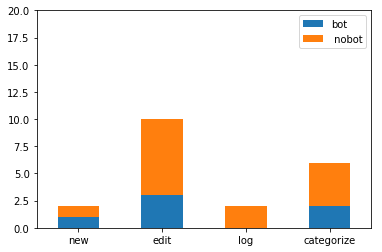

In [26]:
# Tally the bots and types
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
%matplotlib inline
from collections import Counter

@catchInterrupt
def tally_bot(view, ele_window=20, iter=20):
    """bots vs human updates 
    Args:
        view: Streams view that data will be fetched from
        ele_window : max number of elements in window
        iter: number of times to fetch data; < 0 = until interrupt 
    
    """

    nam_list = ['new', 'edit', 'log', 'categorize']   # Edit types
    view.start_data_fetch()

    # Start a fresh aggregate with each iteration
    while iter != 0:
        iter -= 1
        listTuples= view.fetch_tuples(max_tuples=ele_window, timeout=4)
        cntbot = Counter({key:0 for key in nam_list})
        cntnobot = Counter({key:0 for key in nam_list})
        
        for evt in listTuples:
            if evt['bot']:
                cntbot[evt['type']] += 1
            else:
                cntnobot[evt['type']] += 1
        
        bot_list = [cntbot[key] for key in nam_list]
        nobot_list = [cntnobot[key] for key in nam_list]
        
        df = pd.DataFrame({'bot': bot_list, ' nobot': nobot_list}, index=nam_list)
        df.plot.bar(rot=0, stacked=True)
        plt.ylim(0.0, ele_window)
        plt.show()
        clear_output(wait=True)

view = get_view(instance, job_name="WikiPhase1", view_name="paredAll")
tally_bot(view=view[0])

## Graph the frequency of *bot*less event types: Average and instantaneous

Display the count for the current set ("chunk") of events, along with the average over the last 20 sets, utilizing the 'paredHuman' view. 

In [29]:
# Aggregate over collections ("chunks") of rows by category

class chunking_average:
    """
    Aggregate (take the mean of) values over a sliding window
    of counts per category.
    """
    
    def __init__(self, init_base, mean_elements=20):
        """Initialize chunking_average object with counts of zero
        for each of the categories indicated in init_base.
        
        Args:
        - init_base     : dict whose keys indicate the categories to be
                          aggregated separately (values are ignored)
        - mean_elements : size of the chunk over which to take the mean
        """
        
        # For each category, maintain a deque containing the last mean_elements
        # counts. This represents a sliding window: once the deque is full, each
        # new addition drops the oldest entry.
        self.deques = {key:deque([0],maxlen=mean_elements) for key in init_base.keys()}

    def aggregate(self, chunk):
        """Perform the aggregation (calculate the mean) over the current sliding window
        
        Args:
        - chunk : dict of category:count pairs. Counts (values) are appended to the
                  deque for each category (key), potentially dropping the oldest elements
        
        Returns: dict of category:average-count, with the average computed over the accumulated
                 counts for each category (the sliding window), including the current addition
        """
        
        for key in self.deques.keys():
            if self.deques[key] and chunk[key]: self.deques[key].append(chunk[key])
        
        return {key:mean(self.deques[key]) for key in self.deques.keys()}

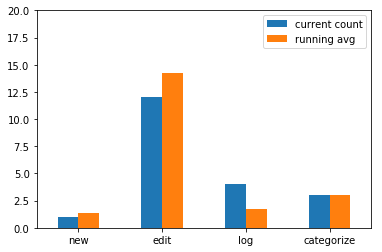

In [30]:
@catchInterrupt
def tally_types(view, ele_window=20, count=20):
    """
    Display a bar chart of the instantaneous count and running-average count per update type.
    
    Args:
    - view: Streams view that data will be fetched from
    - ele_window: max number of elements in window
    - count: number of times to fetch data; < 0 = until interrupt 
    """

    global resp
    nam_list = ['new', 'edit', 'log', 'categorize']
    cnt = {key:0 for key in nam_list}
    run_avg = chunking_average(cnt)
    view.start_data_fetch()

    while count != 0:
        count -= 1
        listTuples= view.fetch_tuples(max_tuples=ele_window, timeout=3)
        cnt = Counter({key:0 for key in nam_list})
        for evt in listTuples:
            cnt[evt['type']] += 1
        
        avg = run_avg.aggregate(cnt)
        evt_list = [cnt[key] for key in nam_list]
        avg_list = [avg[key] for key in nam_list]
        df = pd.DataFrame({'current count': evt_list, 'running avg': avg_list}, index=nam_list)
        df.plot.bar(rot=0)
        plt.ylim(0.0, ele_window)
        plt.show()
        clear_output(wait=True)

view = get_view(instance, job_name="WikiPhase1", view_name="paredHuman")
tally_types(view=view[0])

# Cancel job when done 

In [31]:
list_jobs(instance, cancel=True)

# Notebook wrapup 

This notebook composed and deployed a Streams application that processes live Wikipedia events on a service. After 
filtering the events they're pared down and made avaiable via a view. Using standard notebook widgets
we rendered the view data. 

This application is running on Streams or Streaming Analytics service. Once deployed it is not necessary to have the notebook open and executing in order to process the data. Future notebooks will collect and average data over windows of events and time. 